# Testing Python Rupture Package 

Link: https://pypi.org/project/ruptures/

What we are trying to replicate in python: MATLAB change function - ischange
Python function equivalent to MATLAB ischange function is ruptures package

* Import the data profiles - https://data-argo.ifremer.fr/dac/aoml/7902199/profiles/
* read in sprof 
* read in nitrate 
* use rupture package 
* see what you get/find out about the connection to ischange function


## Ruptures Playground

In [2]:
#pip install ruptures

### Set up of Libraries

In [3]:
import ruptures as rpt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
import os

### Reading in the data

In [4]:
#Getting current working directory for the path to the data file
cwd = os.getcwd()

#reading in the data 
file2read = netCDF4.Dataset(cwd + r'\7902199_Sprof.nc', 'r')

#viewing all of the variables in the file
print(file2read.variables.keys())


dict_keys(['DATA_TYPE', 'FORMAT_VERSION', 'HANDBOOK_VERSION', 'REFERENCE_DATE_TIME', 'DATE_CREATION', 'DATE_UPDATE', 'PLATFORM_NUMBER', 'PROJECT_NAME', 'PI_NAME', 'STATION_PARAMETERS', 'CYCLE_NUMBER', 'DIRECTION', 'DATA_CENTRE', 'PARAMETER_DATA_MODE', 'PLATFORM_TYPE', 'FLOAT_SERIAL_NO', 'FIRMWARE_VERSION', 'WMO_INST_TYPE', 'JULD', 'JULD_QC', 'JULD_LOCATION', 'LATITUDE', 'LONGITUDE', 'POSITION_QC', 'POSITIONING_SYSTEM', 'CONFIG_MISSION_NUMBER', 'PARAMETER', 'SCIENTIFIC_CALIB_EQUATION', 'SCIENTIFIC_CALIB_COEFFICIENT', 'SCIENTIFIC_CALIB_COMMENT', 'SCIENTIFIC_CALIB_DATE', 'PROFILE_PRES_QC', 'PROFILE_TEMP_QC', 'PROFILE_PSAL_QC', 'PROFILE_DOXY_QC', 'PROFILE_BBP700_QC', 'PROFILE_CHLA_QC', 'PROFILE_CDOM_QC', 'PROFILE_PH_IN_SITU_TOTAL_QC', 'PROFILE_NITRATE_QC', 'PRES', 'PRES_QC', 'PRES_ADJUSTED', 'PRES_ADJUSTED_QC', 'PRES_ADJUSTED_ERROR', 'TEMP', 'TEMP_QC', 'TEMP_dPRES', 'TEMP_ADJUSTED', 'TEMP_ADJUSTED_QC', 'TEMP_ADJUSTED_ERROR', 'PSAL', 'PSAL_QC', 'PSAL_dPRES', 'PSAL_ADJUSTED', 'PSAL_ADJUSTED_

### Using the Pelt algorithm

Change Point Detection: Use the ruptures library to detect change points. 
* The model parameter --> specifies the type of model to use for change point detection. 
* The pen parameter --> controls the sensitivity of the algorithm to changes. 
* The higher the penalty, the fewer change points will be detected.

Change Points: The result will contain the indices where the change points are detected.

In [5]:
# Selecting a variable: NO3
nitrate = file2read.variables['NITRATE'][:]  #extracting a numpy array

#PELT model
algo = rpt.Pelt(model="rbf").fit(nitrate)  
result = algo.predict(pen=10)

print(type(nitrate))
print(result)

<class 'numpy.ma.core.MaskedArray'>
[39]


In [6]:
nitrate

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, 2.5546364784240723, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True, False,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=99999.0,
  dtype=float32)

Its stating there is a change point in the index of 39 (corresponds to the 40th observation) and the nitrate concentration shifts. 

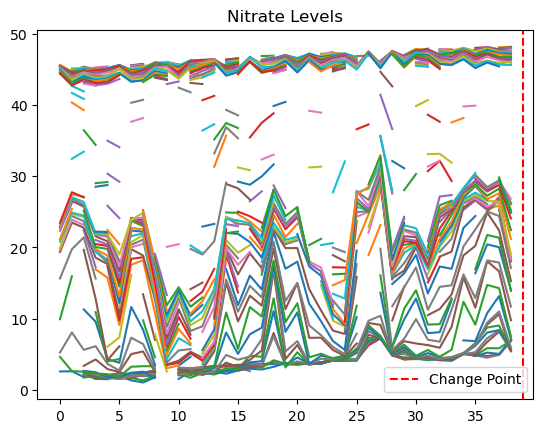

In [7]:
plt.plot(nitrate)
plt.axvline(x=39, color='red', linestyle='--', label="Change Point")
plt.legend()
plt.title("Nitrate Levels")
plt.show()

To see if there are multiple change points --> lowering pen or using Binseg instead of Pelt
* A higher penalty results in fewer change points, meaning the algorithm is stricter about detecting changes
* A lower penalty allows more change points, more sensitive to variations

In [8]:
algo = rpt.Binseg(model="rbf").fit(nitrate)
result = algo.predict(n_bkps=2)  #detecting 2 breakpoints
print(result)

[10, 35, 39]


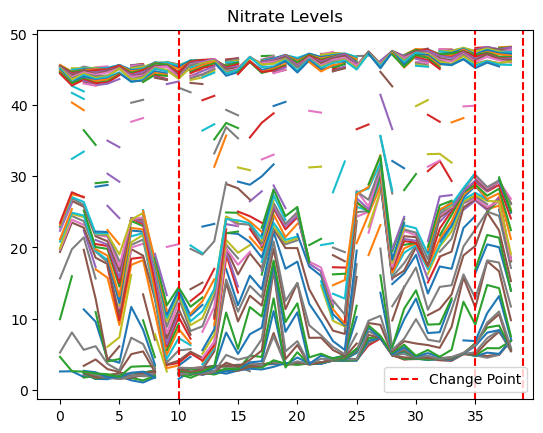

In [9]:
plt.plot(nitrate)
plt.axvline(x=10, color='red', linestyle='--', label="Change Point")
plt.axvline(x=35, color='red', linestyle='--')
plt.axvline(x=39, color='red', linestyle='--')

plt.legend()
plt.title("Nitrate Levels")
plt.show()

## Working with Profiles - PRES & NITRATE

In [10]:
pres = file2read.variables['PRES'][:]
nitrate = file2read.variables['NITRATE'][:]

# Close dataset
file2read.close()

In [11]:
pres

masked_array(
  data=[[2.0, 3.9000000953674316, 5.900000095367432, ..., --, --, --],
        [0.699999988079071, 2.0999999046325684, 4.0, ..., --, --, --],
        [2.299999952316284, 4.0, 6.0, ..., --, --, --],
        ...,
        [2.299999952316284, 4.0, 6.099999904632568, ..., --, --, --],
        [2.299999952316284, 4.0, 6.0, ..., --, --, --],
        [2.0999999046325684, 4.0, 6.0, ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=99999.0,
  dtype=float32)

In [12]:
good_nitrate_mask = ~np.isnan(nitrate)  #returns a mask where True where values are good nirtrate vals and False is the NaNs
good_pres = pres[good_nitrate_mask] #getting only the pres vals where there is nitrate data 
good_nitrate = nitrate[good_nitrate_mask] #removing NaN 

#new array containing only good nitrate values and the matching pres vals
filtered_data = np.column_stack((good_pres, good_nitrate))
filtered_data

masked_array(
  data=[[2.0000e+00, 9.9999e+04],
        [3.9000e+00, 9.9999e+04],
        [5.9000e+00, 9.9999e+04],
        ...,
        [9.9999e+04, 9.9999e+04],
        [9.9999e+04, 9.9999e+04],
        [9.9999e+04, 9.9999e+04]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [13]:
max_good_nitrate_vals = np.sum(good_nitrate_mask, axis=0)  #counts the number of True values (good no3 vals) along the profile axis
print(f"Max good nitrate values per profile: {np.max(max_good_nitrate_vals)}") #finds the max number of valid nitrate values across all profiles and prints


Max good nitrate values per profile: 39


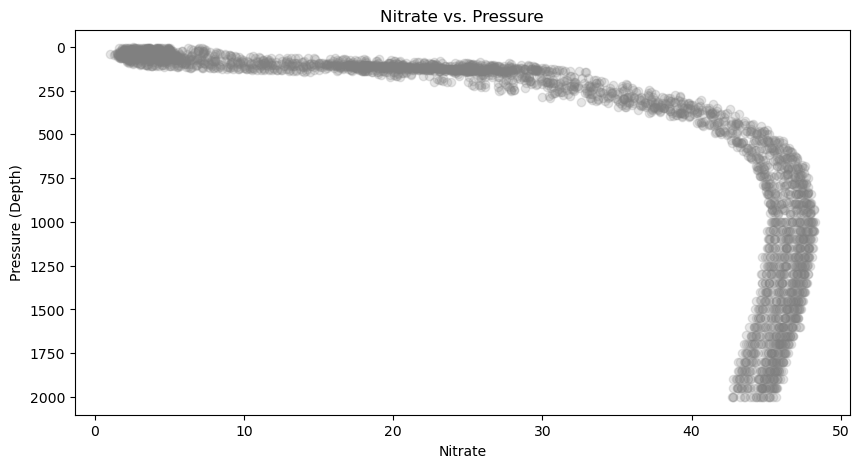

In [14]:
plt.figure(figsize=(10, 5))

# Section Plot: Nitrate vs. Pressure (Depth)
plt.scatter(good_nitrate, good_pres, c='grey', alpha=0.2)
plt.xlabel('Nitrate')
plt.ylabel('Pressure (Depth)')
plt.title('Nitrate vs. Pressure')
plt.gca().invert_yaxis()  # Flip y-axis to show depth 
plt.show()


#### Looking at data close to 1500 dBar

In [15]:
threshold = 50  #values within ±50 decibar

#pres vals close to 1500 decibar
near_1500_mask = (good_pres >= 1500 - threshold) & (good_pres <= 1500 + threshold)

#grabbing corresponding nitrate values
filtered_pres = good_pres[near_1500_mask]
filtered_nitrate = good_nitrate[near_1500_mask]


In [16]:
#use rupture pkge
algo = rpt.Pelt(model="rbf").fit(filtered_nitrate)
result = algo.predict(pen=5)  # Adjust penalty value for tuning

print("Detected change points:", result)


Detected change points: [15, 35, 50, 76]
